<a href="https://colab.research.google.com/github/tryambak2019/SGAN/blob/master/Gr3_AISCProject_SSL_GAN_MNIST_tk_1109_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


SGAN Implementation
==============

Credit to  `Augustus Odena <https://arxiv.org/abs/1606.01583>` for the original paper this is based on.




In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

import time

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# Create directory to store images from Generator after each epoch
# to keep track of Generator performance
directory = "imagesMNIST"
if not os.path.exists(directory):
  os.makedirs(directory)

In [0]:
ls -l

total 8
drwxr-xr-x 2 root root 4096 Sep 11 13:38 imagesMNIST/
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data/


In [0]:
# Root directory for dataset
dataroot = '/content'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) 
                      else "cpu")

0it [00:00, ?it/s]

9920512it [00:03, 2932549.73it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 57441.98it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 944865.48it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 21442.34it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
==>>> Total number of training batches: 2400


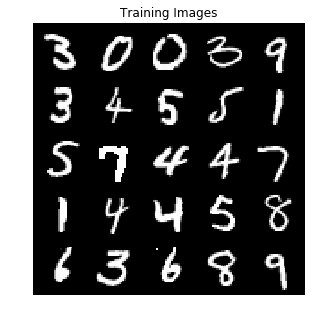

In [0]:
# Create directory MNNIST, download and store MNIST data from pytorch to it

trans = transforms.Compose([transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(), 
                            transforms.Normalize([0.5], [0.5])])

train_set = dset.MNIST(root='./', train=True, transform=trans,
                       download = True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

print ('==>>> Total number of training batches: {}'.format(len(train_loader)))

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25],
                                         padding=2, normalize=True,
                                         nrow = 5).cpu(),
                        (1,2,0)))


# Number of channels in the training images. For color images this is 3
nc = 1

num_classes = 10

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, 
         batch_norm=True, init_zero_weights=False):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride,
                           padding=padding, bias=False)
    if init_zero_weights:
        conv_layer.weight.data = torch.randn(out_channels, in_channels, 
                                             kernel_size, kernel_size) * 0.001
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1,
           batch_norm=True, bias=False):
    """Creates a transposed-convolutional layer, with optional batch
       normalization.
    """
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                     stride, padding, bias=bias))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.Linear1 = nn.Linear(nz, 128 * 7 * 7)
        self.convT1 = deconv(128, 128, 4, 2, 1)
        self.convT2 = deconv(128, 128, 4, 2, 1)
        self.output = deconv(128, nc, 1, 1, 0, batch_norm=False)

    def forward(self, input):
        out = F.leaky_relu(self.Linear1(input.squeeze()), inplace=True)
        out = out.reshape(-1,128,7,7)
        out = F.leaky_relu(self.convT1(out), inplace=True)
        out = F.leaky_relu(self.convT2(out), inplace=True)
        out = self.output(out)

        return torch.tanh(out)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
print (fake.shape)

Generator(
  (Linear1): Linear(in_features=100, out_features=6272, bias=True)
  (convT1): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convT2): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)
torch.Size([25, 1, 28, 28])


In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.num_classes = num_classes
        self.conv1 = conv(nc, 128, 3, 2, 1)
        self.conv2 = conv(128, 128, 3, 2, 1)
        self.conv3 = conv(128, 128, 3, 2, 1)
        self.Linear = nn.Linear(128*4*4, self.num_classes)


    def forward(self, input):
        out = F.leaky_relu(self.conv1(input), inplace=True)
        out = F.leaky_relu(self.conv2(out), inplace=True)
        out = F.leaky_relu(self.conv3(out), inplace=True)
        out = out.view(-1,128*4*4)
        out = self.Linear(out)
        xe = torch.exp(out)
        logexpsum = xe.sum(dim = -1)
        adv = logexpsum / (logexpsum + 1)
        aux = F.softmax(out.squeeze(), dim = 1)

        return adv, aux

# Create the Discriminator
num_classes = 10
netD = Discriminator(ngpu, num_classes).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


noise = torch.randn(batch_size, 1, 28, 28, device=device)
adv, aux = netD(noise)
print (aux.shape)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Linear): Linear(in_features=2048, out_features=10, bias=True)
)
torch.Size([25, 10])


In [0]:
# Initialize BCELoss function
criterion_adv = nn.BCELoss()
criterion_aux = nn.CrossEntropyLoss()

if (device.type == 'cuda') and (ngpu > 1):
  criterion_adv.cuda()
  criterion_aux.cuda()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
checkpoint_dir = '/content/MNIST_Check/'

def create_dir(directory):
    """Creates a directory if it does not already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

create_dir(checkpoint_dir)

def checkpoint(epoch, G, D, optimizerG,optimizerD, lossG, lossD):
    """
    Saves the parameters of the generator G and discriminator D.
    """
    GAN_path = os.path.join(checkpoint_dir, 'GAN.pkl')    

    torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'lossG': lossG,
            'lossD': lossD
            }, GAN_path)
    
def load_checkpoint(model, checkpoint_name):
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 
                                                  checkpoint_name)))

In [0]:
print(batch_size)
print(len(train_loader))

25
2400


In [0]:
# Lists to keep track of progress
img_list = []
img_list_fixedN = []
G_losses = []
D_losses = []
iters = 0

sample_interval = 100
num_epochs = 20
len_train_loader = len(train_loader)

supervised_batch = batch_size // 2

netD.train()
netG.train()
t0 = time.time()
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
# for epoch in range(1):
    # For each batch in the dataloader

    for i, (imgs, labels) in enumerate(train_loader, 0):
      # Format batch
        real_data = imgs.to(device)
        b_size = real_data.size(0)
        label_real_adv = torch.full((b_size,), real_label, device=device, 
                               requires_grad=False)
        label_fake_adv = torch.full((b_size,), fake_label, device=device,
                                    requires_grad=False)
        
        netG.zero_grad()
        netD.zero_grad()
		# update supervised discriminator (aux)
        ix = np.random.randint(0, b_size, supervised_batch)
        Isup_real, Lsup_real = real_data[ix], labels[ix]
        _, auxSup = netD(Isup_real)
        auxSup_loss = criterion_aux(auxSup, Lsup_real.to(device))

		# update unsupervised discriminator (adv)
        advUnsup, _ = netD(real_data)
        errD_real = criterion_adv(advUnsup, label_real_adv)


        # optimizerG.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        adv_fake, _ = netD(fake.detach())
        errD_fake = criterion_adv(adv_fake.view(-1), label_fake_adv)


        # Add the gradients from the all-real and all-fake batches
        errD_unsup = 0.5 * (errD_real + errD_fake)
        errD = errD_unsup + auxSup_loss
        errD.backward()
        # Update D
        optimizerD.step()


		# update generator (g)
	      # netG.zero_grad()
        adv_g, _ = netD(fake)
        errG = criterion_adv(adv_g.view(-1), label_real_adv)
        errG.backward()

        # Update G
        optimizerG.step()

        
        # Calculate discriminator accuracy
        pred = np.concatenate([auxSup.data.cpu().numpy(),
                              ], axis=0)
        gt = np.concatenate([Lsup_real.data.cpu().numpy(),
                            ], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        # Output training stats
        if i % (len_train_loader/2) == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tAcc: %d%%\tTot Time: %d secs'
                    % (epoch, num_epochs, i, len_train_loader,
                     errD.item(), errG.item(), 100 * d_acc, time.time() - t0))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % (len_train_loader/2) == 0) or ((epoch == num_epochs-1)
                                          and (i == len_train_loader-1)):
          batches_done = epoch * len_train_loader + i
          with torch.no_grad():
                fake_fixed = netG(fixed_noise).detach().cpu()
          img_list_fixedN.append(vutils.make_grid(fake_fixed.detach().cpu(),
                                           padding=2, normalize=True))
          save_image(fake_fixed.data[:], 
                       dataroot + "/imagesMNIST/fixedN%d.png" % batches_done,
                       nrow=5, normalize=True)

        iters += 1

    checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses)

Starting Training Loop...
[0/20][0/2400]	Loss_D: 3.6598	Loss_G: 0.8057	Acc: 16%	 0 secs
[0/20][1200/2400]	Loss_D: 1.7415	Loss_G: 3.1108	Acc: 100%	 70 secs
[1/20][0/2400]	Loss_D: 2.0043	Loss_G: 2.6231	Acc: 100%	 140 secs
[1/20][1200/2400]	Loss_D: 1.7704	Loss_G: 3.2263	Acc: 100%	 210 secs
[2/20][0/2400]	Loss_D: 1.7598	Loss_G: 3.9744	Acc: 100%	 281 secs
[2/20][1200/2400]	Loss_D: 1.9139	Loss_G: 4.6372	Acc: 91%	 351 secs
[3/20][0/2400]	Loss_D: 1.7242	Loss_G: 3.8905	Acc: 100%	 421 secs
[3/20][1200/2400]	Loss_D: 1.5435	Loss_G: 4.1865	Acc: 100%	 491 secs
[4/20][0/2400]	Loss_D: 1.6082	Loss_G: 3.7928	Acc: 100%	 562 secs
[4/20][1200/2400]	Loss_D: 1.6523	Loss_G: 4.1333	Acc: 83%	 632 secs
[5/20][0/2400]	Loss_D: 1.6872	Loss_G: 5.7417	Acc: 100%	 702 secs
[5/20][1200/2400]	Loss_D: 1.4875	Loss_G: 4.8639	Acc: 100%	 772 secs
[6/20][0/2400]	Loss_D: 1.7658	Loss_G: 4.8709	Acc: 100%	 842 secs
[6/20][1200/2400]	Loss_D: 1.7753	Loss_G: 6.3922	Acc: 100%	 912 secs
[7/20][0/2400]	Loss_D: 1.9219	Loss_G: 6.9556	Acc:

Results
-------

Finally, lets check out how we did. Here, we will look at three different results.

First, we will see how D and G’s losses changed
during training.

Second, we will evaluate Discriminator's performance on trining dataset.

And third, we will compare a batch of real data
for Ground Truth to the predicted values.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




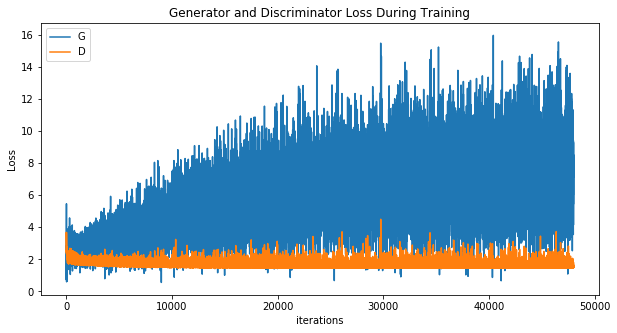

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#Load trained model

# print (checkpoint_dir)
# GAN_path = os.path.join(checkpoint_dir, 'GAN.pkl')

# if (device):
#   checkpoint = torch.load(GAN_path, map_location = 'cpu')

# netD.load_state_dict(checkpoint['D_state_dict'])

/content/gdrive/My Drive/Colab Notebooks/AISC/GAN/MNIST_Check2CB/


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

400


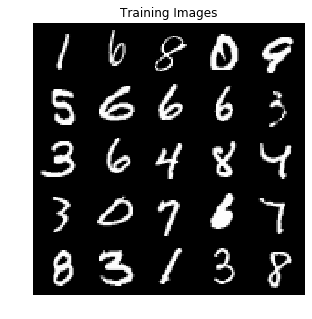

In [0]:
trans = transforms.Compose([transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(), 
                            transforms.Normalize([0.5], [0.5])])

test_set = dset.MNIST(root='./data', train=False, transform=trans)

test_loader = torch.utils.data.DataLoader(
                 dataset=test_set,
                 batch_size=25,
                 shuffle=True)

print ('==>>> Total number of testing batches: {}'.format(len(test_loader)))

# Plot some testing images
real_batch = next(iter(test_loader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25],
                                         padding=2, normalize=True,
                                         nrow = 5).cpu(),
                        (1,2,0)))

In [0]:
netD.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for imgs, labels in test_loader:
      adv, aux = netD(imgs.to(device))
      test_loss += F.nll_loss(aux, labels.to(device), size_average=False).item()
      pred = aux.data.max(1, keepdim=True)[1]
      correct += pred.eq(labels.to(device).data.view_as(pred)).sum()
  
test_loss /= len(test_loader.dataset)
# test_loss.append(test_loss)
  
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.9849, Accuracy: 9876/10000 (98%)



##**Check the predicted value against Ground Truth**

GroundTruth:      6     6     6     0     8     1     0     3     6     5     1     2     7     8     0     3     2     5     2     3     5     9     1     8     3
Predicted:        6     6     6     0     8     1     0     3     6     5     1     2     7     8     0     3     2     5     2     3     5     9     1     8     3


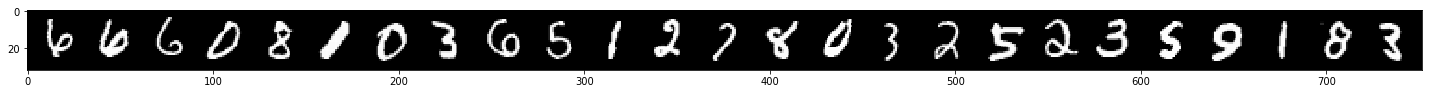

In [0]:
# dataiter = iter(test_loader)
images, labels = next(iter(test_loader))

no_of_data = min(30, images.shape[0])

# print images
plt.figure(figsize=(no_of_data,no_of_data))
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:no_of_data],
                                         padding=2, normalize=True,
                                         nrow = no_of_data).cpu(),
                        (1,2,0)))

print('GroundTruth: ', ' '.join('%5s' 
                                % labels[j].item() for j in range(no_of_data)))


adv, aux = netD(images.to(device))
_, predicted = torch.max(aux, 1)

print('Predicted:   ', ' '.join('%5s' 
                              % predicted[j].item() for j in range(no_of_data)))

# references

https://pytorch.org/docs/stable/torch.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://nextjournal.com/gkoehler/pytorch-mnist

https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/

https://arxiv.org/abs/1606.01583